In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [6]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [7]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [8]:
# Chat function to provide it to Gradio

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

In [50]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499", "bangalore": "$150", "delhi": "$100"}

def get_ticket_prices(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [51]:
get_ticket_prices("Delhi")

Tool get_ticket_price called for Delhi


'$100'

In [52]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example" + 
                    "when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to"
            }
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
    
}

In [53]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [64]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [65]:
# we have to write that function handle_tool_call:
# Handles a tool call from the OpenAI chat completion API, 
# specifically for retrieving ticket prices for a given destination city.

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_prices(city)
    print(f"Price is: {price}")
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": str(tool_call.id)
    }
    return response, city


In [66]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Delhi
Price is: $100


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents.

In [15]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [33]:
def artist(city):
    prompt=(f"An image representing a vacation in city {city},"
            f"showing tourist spots and everything unique about {city}, in a vibrant pop-art style")
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size='1024x1024',
        response_format='b64_json'
    )
    image_base64 = image_response.data[0].b64_json # Extracts the base64-encoded image from the response.
    image_data = base64.b64decode(image_base64) # Decodes the base64 string into binary image data.
    return Image.open(BytesIO(image_data)) # Loads the image into a PIL Image object from the binary data.

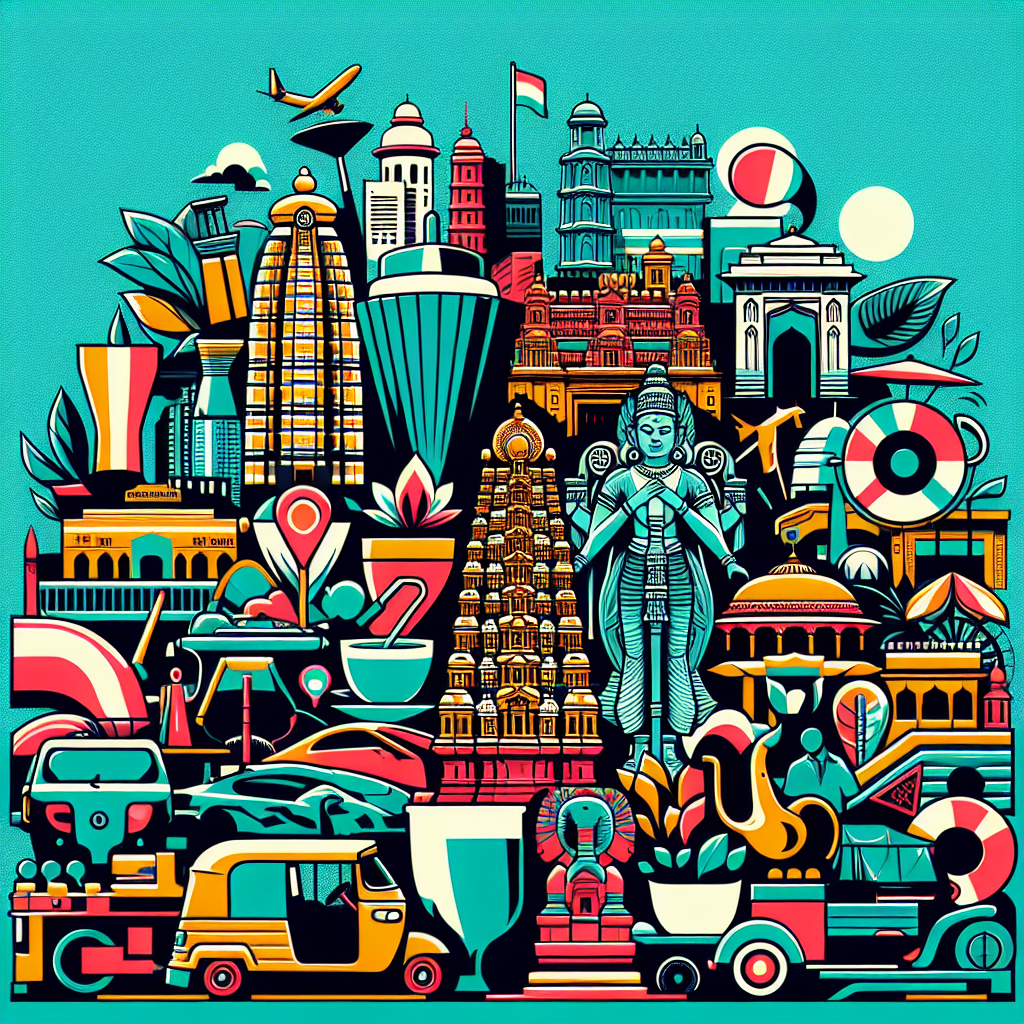

In [18]:
image = artist("Bangalore")
# display is a built-in function in Jupyter/IPython environments (from IPython.display).
# It works for images, plots, audio, video, and more.
display(image)

### Let's make a function talker that uses OpenAI's speech model to generate Audio.

**Troubleshooting Audio issues**

If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

**For Mac**

1. Install homebrew if you don't have it already by running this in a Terminal window and following any instructions:  
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Then install FFmpeg with `brew install ffmpeg`

3. Verify your installation with `ffmpeg -version` and if everything is good, within Jupyter Lab do Kernel -> Restart kernel to pick up the changes

In [54]:
# import to support Audio model to generate speech.
from io import BytesIO
import tempfile
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
from pydub import AudioSegment
import simpleaudio as sa

In [55]:
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice='onyx',
        input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Create a temporary file in a folder where you have write permissions
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents/LLM_Project/ai_agent_llm/agent/7-Image-Audio-LLM")) as temp_audio_file:
        temp_file_name = temp_audio_file.name
        audio.export(temp_file_name, format="wav")
    
    # Load and play audio using simpleaudio
    wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
    play_obj = wave_obj.play()
    play_obj.wait_done() # Wait for playback to finish

    # Clean up the temporary file afterward
    os.remove(temp_file_name)

In [36]:
# The above talker function just repeat whatever the test it has been given, To enable the voice modal to 
# understand and reply the text, we need to make below abjustment

def conversationAgent(message):
    
    response = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=[
            {"role": "system", "content": "You are a helpful assistant. Try to give accurate information on whatever is being asked.s"},
            {"role": "user", "content": message}
        ]
    )

    reply_text = response.choices[0].message.content
    print(f"reply: {reply_text}")
    return talker(reply_text)

In [ ]:
# Calling the talker
# talker("Well, Hi there.")
# conversationAgent("Hi, In kannada language say, My name is Abhishek, what is your Name?.")

reply: In Kannada, you would say: "ನನ್ನ ಹೆಸರು ಅಭಿಷೇಕ್, ನಿಮ್ಮ ಹೆಸರೇನು?" (Nanna hesaru Abhishek, ninna hesarenu?)


# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

In [71]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        # Optionally generate image and re-run the chat with plain dict messages
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)


    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]

    talker(reply)

    return history, image

In [72]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Delhi
Price is: $100
